# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation


In [2]:
from google.colab import files

uploaded = files.upload()

Saving tweets_coronavirus.csv to tweets_coronavirus (1).csv


In [3]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,Positive
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,Extremely Positive
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
def sentiment_to_binary(sentiment):
    if sentiment in ['Positive', 'Extremely Positive']:
        return 1
    elif sentiment in ['Negative', 'Extremely Negative']:
        return 0

# Применение функции к каждому значению в колонке Sentiment
df['Sentiment'] = df['Sentiment'].apply(sentiment_to_binary)


Сбалансированы ли классы?

In [5]:
# -- YOUR CODE HERE --
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Можем сказать, что очень сильного разброса нет, поэтому классы скорее более сбалансированны, чем нет.

**Ответ:** # -- YOUR ANSWER HERE --

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
# -- YOUR CODE HERE --
print(df.isnull().sum())
df['Location'] = df['Location'].fillna('Unknown')
df

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


У признака Location есть пропуски

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, test_size=0.3, shuffle=True, random_state=0
)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [8]:
# -- YOUR CODE HERE --
d = {} # создадим словарь где будут храниться наши твиты
for twit in train['OriginalTweet']:
  twit = twit.lower().split()
  for word in twit:
    if word in d.keys():
      d[word] +=1
    else:
      d[word] = 1






Какой размер словаря получился?

In [9]:
# -- YOUR CODE HERE --
print(len(d))


79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [10]:
# -- YOUR CODE HERE --

sorted_d = sorted(d, key=d.get, reverse=True)

for key in sorted_d[:10]:
  print(key, d[key])

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


Эти токены в топе, потому что чаще всего встречаются для связки слов, мы тут видим в основном артикли, предлоги

> Добавить блок с цитатой



Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [11]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
stopword = stopwords.words("english")


for word in stopword:
  if word in d.keys():
    del d[word]

d_bez_sw = sorted(d, key=d.get, reverse=True)

for key in d_bez_sw[:10]:
  print(key, d[key])








#coronavirus 8223
prices 3891
food 3820
grocery 3469
supermarket 3288
people 3175
covid-19 3173
store 3155
#covid19 2471
&amp; 2314


После удаления уже замечается некая общая тема, а именно ковидного времени, а так же различных тем, связанных с ним, такие как покупки, магазины, цены, кризис и так далее

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [12]:
# -- YOUR CODE HERE --
d_bez_sw1 = sorted(d, key=d.get, reverse=False)

for key in d_bez_sw1[:20]:
  print(key, d[key])






https://t.co/1m881cwfuv 1
happy.. 1
https://t.co/z0intks34x 1
mnuchinãâs 1
brink. 1
https://t.co/jmobv8z0u0 1
university's 1
teaching.) 1
@catholicpres 1
@catholicuniv 1
https://t.co/evqby035wf 1
https://t.co/riqrhxxeim 1
@@ballardspahrll 1
#aca 1
easier...take 1
ãânecessaryãâ 1
https://t.co/0fmsmlgepm 1
husted: 1
irishman 1
#happystpatricksday! 1


**Ответ:** Эти токены непопулярны, так в них присутствуют конкретные ссылки и рахличные символы. С данными токенами скорее всего не стоит отдельно работать, так как они очень узконаправленные и будет тяжело заметить связь между твитом.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()

d_new = {}
for twit in train['OriginalTweet']:
  twit = tw.tokenize(twit)
  for word in twit:
    if word.lower() in d_new.keys():
      d_new[word.lower()] +=1
    else:
     d_new[word.lower()] = 1


sorted_d_new = sorted(d_new, key=d_new.get, reverse=True)

for key in sorted_d_new[:10]:
  print(key, d_new[key])

# -- YOUR CODE HERE --

the 26993
. 24118
to 23478
, 17571
and 14825
of 13044
a 11891
in 11348
? 9524
#coronavirus 8808


**Ответ:** Видно, что появилось множество отдельных символов, так как  TweetTokenizer отделяет их, поэтому можно сказать о существенном различии с предыдущим делением на токены.


Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)

for word in noise:
  if word.lower() in d_new.keys():
    del d_new[word]



sorted_d_new_clear = sorted(d_new, key=d_new.get, reverse=True)

for key in sorted_d_new_clear[:10]:
  print(key, d_new[key])




# -- YOUR CODE HERE --

#coronavirus 8808
â 7415
 7311
19 7167
covid 6253
prices 4601
 4372
food 4367
store 3877
supermarket 3805


**Ответ:** В новом топе появились непонятные символы, которые трудно интпретировать

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
# -- YOUR CODE HERE --


d_new_1= d_new.copy()

for key in d_new_1.keys():
  if len(key.lower()) == 1 and all(ord(char) >= 128 for char in key.lower()) :
    del d_new[key]

sorted_d_new_clear_2 = sorted(d_new, key=d_new.get, reverse=True)

for key in sorted_d_new_clear_2[:10]:
  print(key, d_new[key])

sorted_d_new_clear_3 = sorted(d_new, key=d_new.get, reverse=False)
print()
for key in sorted_d_new_clear_3[:20]:
  print(key, d_new[key])

#coronavirus 8808
19 7167
covid 6253
prices 4601
food 4367
store 3877
supermarket 3805
grocery 3523
people 3463
#covid19 2589

https://t.co/1m881cwfuv 1
https://t.co/z0intks34x 1
mnuchinã 1
https://t.co/jmobv8z0u0 1
university's 1
@catholicpres 1
@catholicuniv 1
https://t.co/evqby035wf 1
https://t.co/riqrhxxeim 1
@ballardspahrll 1
#aca 1
https://t.co/0fmsmlgepm 1
irishman 1
#happystpatricksday 1
guiness 1
https://t.co/18v0pyhwb7 1
https://t.co/ls0g86i8pu 1
https://t.co/ofvkejff23 1
https://t.co/xoodgd2ulx 1
lifestyles 1


**Ответ:** Данный топ сузил нашу общую тему твитов, а именно влияение ковида на изменине цен в магазинах.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [16]:
# -- YOUR CODE HERE --
heshtag = {} # пустой словарь для хештегов
for word in d_new.keys():
  if word[0] == '#':
    heshtag.update({word:d_new[word]})

sorted_d_ht = sorted(heshtag, key=heshtag.get, reverse=True) #Сортируем по значению

for key in sorted_d_ht[:10]: #Выводим первые 10
  print(key, heshtag[key])


#coronavirus 8808
#covid19 2589
#covid_19 1734
#covid2019 946
#toiletpaper 744
#covid 641
#socialdistancing 465
#coronacrisis 448
#pandemic 257
#coronaviruspandemic 249


**Ответ:** Можем заметить, что все хештеги связаны с ковидом, оно и неудивительно, ведь все твиты были сделаны во время эпидемии

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
# -- YOUR CODE HERE --

link = {} # пустой словарь для ccылок
for word in d_new.keys():
  if word.startswith('https://t.co'):
    link.update({word:d_new[word]})

sorted_d_link = sorted(link, key=link.get, reverse=True) #Сортируем по значению

for key in sorted_d_link[:10]: #Выводим первые 10
  print(key, d_new[key])


https://t.co/oxa7swtond 5
https://t.co/gp3eusapl8 4
https://t.co/deftrui1pfãâ 3
https://t.co/wrlhyzizaa 3
https://t.co/kuwipf1kqw 3
https://t.co/zjnrx6dkkn 3
https://t.co/3gbbdpdjat 3
https://t.co/e2znxajpre 3
https://t.co/catkegayoy 3
https://t.co/g63rp042ho 3


**Ответ:** Ссылок токенов буквально единицы, их гораздо меньше,информация о ссылке будет не совсем полезна для анализа твитов.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [18]:

def custom_tokenizer(text):

  text_1 = text.lower()
  list_tokens = tw.tokenize(text_1)
  uni_list = [char for char in list_tokens if len(char) == 1 and ord(char) >= 128]

  tokens = [
      token for token in list_tokens if token not in noise and token not in uni_list and token[0:12] != 'https://t.co'
      ]

  return tokens


In [19]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)
cv.fit_transform(train['OriginalTweet'])





print(len(cv.vocabulary_))


# # -- YOUR CODE HERE --


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Словарь стал почти в 2 раза меньше.

Посмотрим на какой-нибудь конкретный твитт:

In [21]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [22]:
# -- YOUR CODE HERE --
vectorized_text = cv.fit_transform([train.iloc[ind]['OriginalTweet']])
vectorized_text.toarray()




array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Ответ:** В данном тексте все слова всречаются по одному разу, поэтому данный метод не позволяет выявить важные и неважные токены.





Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [23]:
# -- YOUR CODE HERE --
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(tokenizer = custom_tokenizer)

vec_text = tf.fit_transform(train['OriginalTweet'])
v = pd.DataFrame(vec_text.toarray(), columns=tf.get_feature_names_out()).iloc[[ind]]
v = v.drop(columns=v.columns[v.iloc[0] == 0])
v



,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


In [24]:
max_v_name = v.idxmax(axis=1)
min_v_name = v.idxmin(axis=1)

print(f'Cамый важный токен - {list(max_v_name)[0]}')
print(f'Cамый неважный токен - {list(min_v_name)[0]}')



Cамый важный токен - brainless
Cамый неважный токен - food


**Ответ:** # Даннный метод уже позволил нам выявить самый важный и неважный токен в конкретном твите.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [25]:
train.reset_index(drop = True , inplace = True)
train[train['OriginalTweet'].apply(lambda x: 'brilliant' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
110,33331,78283,Unknown,05-04-2020,Supermarket staff are doing brilliant. But my ...,1
2426,21040,65992,"Melbourne, Victoria, Australia",23-03-2020,At least I can praise COVID-19 for this. I had...,1
5266,38476,83428,"Manchester, England",08-04-2020,Click here https://t.co/jAeaNRDjT3 for a brill...,1
9158,16496,61448,"Kathmandu, Nepal",21-03-2020,Supermarket In Denmark Uses Price Trick To Sto...,1
10207,39063,84015,South Africa,09-04-2020,Redshift recently built an online store connec...,1
12007,26704,71656,Unknown,25-03-2020,The #coronavirus has renewed the potential for...,1
16692,5405,50357,Yorkshire and The Humber,17-03-2020,Love it when artists see the funny side. Don't...,1
19843,6906,51858,Unknown,18-03-2020,Hand sanitizer was invented by a Latina!??\r\r...,1
20421,11029,55981,DELHI-DUBAI-NEW YORK,19-03-2020,"""I don't think you need to stock your pantry b...",1
20717,25786,70738,Unknown,25-03-2020,The explained brilliantly,1


In [26]:
# -- YOUR CODE HERE --
ind1 = 23120
print(train.iloc[ind1]['OriginalTweet'], train.iloc[ind1]['Sentiment'])

v_1 = pd.DataFrame(data=vec_text.toarray(), columns=tf.get_feature_names_out()).iloc[[ind1]]
v_1 = v_1.drop(columns=v_1.columns[v_1.iloc[0] == 0])
v_1


Absolutely brilliant idea amp a great use of a free gift from An Post Show how much your hospital care home supermarket etc the list is endless workers mean to you during this 19 crisis 1


,19,absolutely,amp,brilliant,care,crisis,endless,etc,free,gift,...,hospital,idea,list,mean,much,post,show,supermarket,use,workers
23120,0.085575,0.259189,0.179137,0.296693,0.196072,0.159202,0.321042,0.208685,0.189624,0.269845,...,0.232834,0.237303,0.223796,0.240497,0.187952,0.217295,0.236476,0.109901,0.182643,0.150058


**Ответ:** Я выбрал положительный твит со словом brilliant, и мы можем увидеть что данный токен на 2 месте по значимости в одном из твитов, что говорит нам что данный  метод хорошо разделил токены, ведь данное слово позволяет судить о положительной окрашенности твита.





## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [27]:
# -- YOUR CODE HERE --
y_train = train['Sentiment']
y_test = test['Sentiment']
X_train = train['OriginalTweet']
X_test = test['OriginalTweet']


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# Воспользуемся сначала CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)

cv_train = cv.fit_transform(X_train)  # bow — bag of words (мешок слов)
cv_test = cv.transform(X_test)



clf = LogisticRegression()
clf.fit(cv_train, y_train)
pred_test = clf.predict(cv_test)
pred_train = clf.predict(cv_train)
print(f'Accuracy для cv на test {accuracy_score(y_test, pred_test)}') # посчитаем долю правильных ответом на тесте
print(f' Accuracy для cv на train {accuracy_score(y_train, pred_train)}') # посчитаем долю правильных ответом на трейне

# -- YOUR CODE HERE --

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy для cv на test 0.8674506677297189
 Accuracy для cv на train 0.9844510892780863


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
tf = TfidfVectorizer(tokenizer = custom_tokenizer)
tf_train = tf.fit_transform(X_train)
tf_test = tf.transform(X_test)

clf = LogisticRegression()
clf.fit(tf_train, y_train)

pred_tfidf_test = clf.predict(tf_test)
pred_tfidf_train = clf.predict(tf_train)

print(f'Accuracy для cv на test {accuracy_score(y_test, pred_tfidf_test)}') # посчитаем долю правильных ответом на тесте
print(f' Accuracy для cv на train {accuracy_score(y_train, pred_tfidf_train)}') # посчитаем долю правильных ответом на трейне



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy для cv на test 0.8533984452860275
 Accuracy для cv на train 0.9254592054677488


**Ответ:** Можем заметить , что на Сountvectorizer-e качество лучше, чем y tfid,а также прослеживается переобучение у CV.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [30]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
tw = TweetTokenizer()

def custom_stem_tokenizer(text):

  text_1 = text.lower()
  list_tokens = tw.tokenize(text_1)
  uni_list = [char for char in list_tokens if len(char) == 1 and ord(char) >= 128]


  tokens = [
      token for token in list_tokens if token not in noise and token not in uni_list and token[0:12] != 'https://t.co'
      ]
  tokens_1  = []
  for slovo in tokens:
    token_stem = stemmer.stem(slovo)
    tokens_1.append(token_stem)

  return tokens_1

In [31]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [32]:
 # -- YOUR CODE HERE --
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
cv.fit_transform(train['OriginalTweet'])


print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


**Ответ** Размер словаря снова уменьшился примерно на 9 тысяч токенов, то есть остались самые значимые слова.*Курсив*

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [33]:
# -- YOUR CODE HERE --
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)

cv_train = cv.fit_transform(X_train)  # bow — bag of words (мешок слов)
cv_test = cv.transform(X_test)



clf.fit(cv_train, y_train)

pred_test = clf.predict(cv_test)
pred_train = clf.predict(cv_train)

print(f'Accuracy для cv на test {accuracy_score(y_test, pred_test)}') # посчитаем долю правильных ответом на тесте
print(f' Accuracy для cv на train {accuracy_score(y_train, pred_train)}') # посчитаем долю правильных ответом на трейне

Accuracy для cv на test 0.8674506677297189
 Accuracy для cv на train 0.9717642033319095


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
tf = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
tf_train = tf.fit_transform(X_train)
tf_test = tf.transform(X_test)

clf = LogisticRegression()
clf.fit(tf_train, y_train)

pred_tfidf_test = clf.predict(tf_test)
pred_tfidf_train = clf.predict(tf_train)

print(f'Accuracy для cv на test {accuracy_score(y_test, pred_tfidf_test)}') # посчитаем долю правильных ответом на тесте
print(f' Accuracy для cv на train {accuracy_score(y_train, pred_tfidf_train)}') # посчитаем долю правильных ответом на трейне


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy для cv на test 0.8560892963922663
 Accuracy для cv на train 0.9158906450234943


**Ответ** В целом изменение токенайзера практически ничего не дало, лишь при TfidVec у нас произошло незначительное улучшение на 0,03.




## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [35]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000# -- YOUR CODE HERE --
                        ).fit(train['OriginalTweet']
                            # -- YOUR CODE HERE --
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [36]:
# -- YOUR CODE HERE --

cv_df_max_train = cv_df.fit_transform(X_train)
cv_df_max_test = cv_df.transform(X_test)

clf.fit(cv_df_max_train, y_train)

print(f"Accuracy для cv на test {accuracy_score(clf.predict(cv_df_max_test),y_test)}")
print(f"Accuracy для cv на train {accuracy_score(clf.predict(cv_df_max_train),y_train)}")

Accuracy для cv на test 0.8681482957942994
Accuracy для cv на train 0.9716360529688167


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Параметр такой большой, так как мы убрали самое одно самое часто встречаемое слово.

**Ответ:**

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [37]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(train['OriginalTweet']

                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [38]:
# -- YOUR CODE HERE --
cv_df_min_train = cv_df.fit_transform(X_train)
cv_df_min_test = cv_df.transform(X_test)

clf.fit(cv_df_min_train, y_train)

print(f"Accuracy для cv на test {accuracy_score(clf.predict(cv_df_min_test),y_test)}")
print(f"Accuracy для cv на train {accuracy_score(clf.predict(cv_df_min_train),y_train)}")

Accuracy для cv на test 0.8677496511859677
Accuracy для cv на train 0.9284493806065783


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** Теперь accuracy достаточно сильно упало на трейне, тем самым мы избавились от переобучения, на тестовой выборке же ничего не изменилось.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [39]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler(with_mean=False)
cv_df_min_train_scaled = scaler.fit_transform(cv_df_min_train)
cv_df_min_test_scaled = scaler.transform(cv_df_min_test)

clf.fit(cv_df_min_train_scaled, y_train)

print(f"Accuracy для cv на test {accuracy_score(clf.predict(cv_df_min_test_scaled),y_test)}")
print(f"Accuracy для cv на train {accuracy_score(clf.predict(cv_df_min_train_scaled),y_train)}")

# -- YOUR CODE HERE --

Accuracy для cv на test 0.8447279250548136
Accuracy для cv на train 0.9416915847928236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


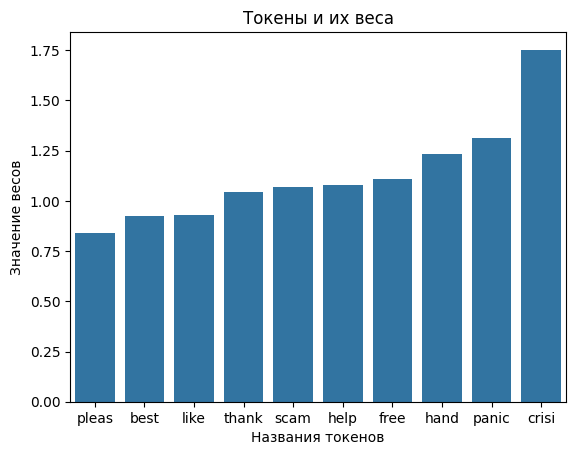

In [40]:
coefs = np.abs(clf.coef_[0])
feature_names = cv_df.get_feature_names_out()
max_w = np.sort(coefs)[-10:]
max_w_indexes = np.argsort(coefs)[-10:]
max_w_names = [feature_names[name] for name in max_w_indexes]

sns.barplot(x = max_w_names, y=max_w)
sns.set(rc={'figure.figsize':(18,10)}) # изменим size графика
plt.title('Токены и их веса')
plt.xlabel('Названия токенов')
plt.ylabel('Значение весов')
plt.show()


**Ответ:** При скалировании наша accuracy еще немного упал на тестовой выборке, на обучающей же снова вырос

Что касается токенов в барплоте, мы можем заметить тут различные слова, связаные с ковидным временем, а именно паникой, кризисом, помощью и так далее.



## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [41]:
# -- YOUR CODE HERE --
train['UserName'].value_counts()

UserName
35178    1
35598    1
26660    1
9581     1
8447     1
        ..
20801    1
30276    1
20045    1
32319    1
7104     1
Name: count, Length: 23410, dtype: int64

In [42]:
train['ScreenName'].value_counts()

ScreenName
80130    1
80550    1
71612    1
54533    1
53399    1
        ..
65753    1
75228    1
64997    1
77271    1
52056    1
Name: count, Length: 23410, dtype: int64

Как мы можем увидеть, значения данных признаков встречаются каждый по одному разу, что делает бессмысленным кодировку и дальнейшее испольхование

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

<ipython-input-43-29927eaa93a4>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])
<ipython-input-43-29927eaa93a4>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y=train['TweetAt'], x=y_train, ci=None, hue=train['TweetAt'])


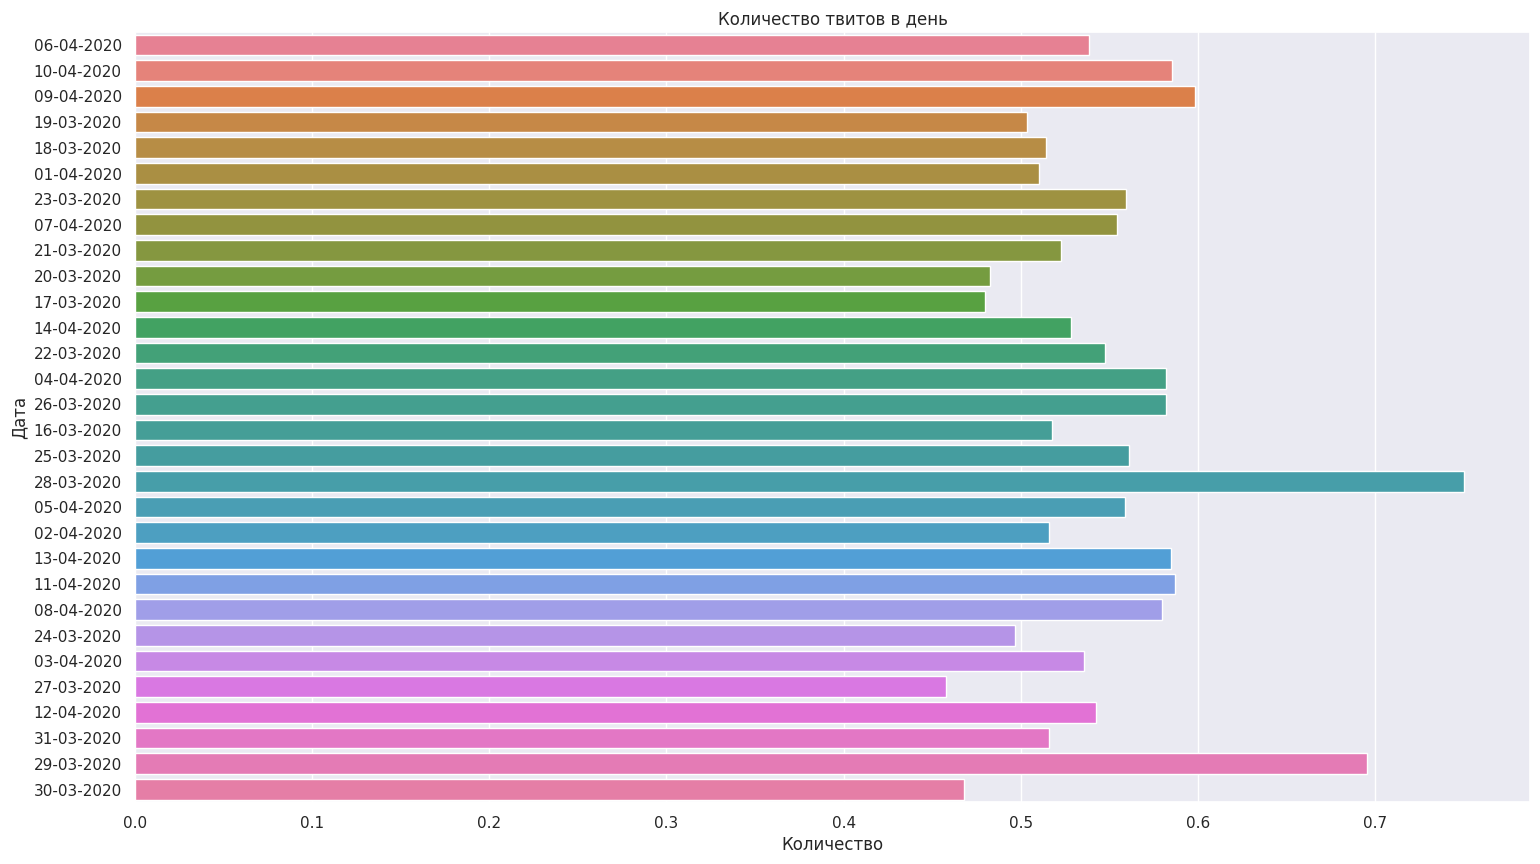

In [43]:
# -- YOUR CODE HERE --

df['TweetAt'] = pd.to_datetime(df['TweetAt'])

sns.barplot(y=train['TweetAt'], x=y_train, ci=None, hue=train['TweetAt'])
sns.color_palette("husl")
plt.title('Количество твитов в день')
plt.xlabel('Количество')
plt.ylabel('Дата')
plt.show()


In [44]:
train_1 = pd.get_dummies(train['TweetAt'], drop_first=False, dtype=int)
df_scaled = pd.DataFrame(data=cv_df_min_train_scaled.toarray(), columns=cv_df.get_feature_names_out())
train_new = train_1.join(df_scaled)
train_new = train_new.loc[:,train_new.columns != 'index']

test_1 = pd.get_dummies(test['TweetAt'], drop_first=False, dtype=int)
df_scaled1 = pd.DataFrame(data=cv_df_min_test_scaled.toarray(), columns=cv_df.get_feature_names_out())
test_1.reset_index(drop = True , inplace = True)
test_1['index'] = test_1.index

df_scaled1['index'] = df_scaled1.index
test_new = test_1.merge(df_scaled1, on='index')
test_new = test_new.loc[:, test_new.columns != 'index']


clf.fit(train_new, y_train)
print(f"Accuracy для cv на train {accuracy_score(clf.predict(train_new),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(clf.predict(test_new),y_test)}")



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy для cv на train 0.9434429730884237
Accuracy для cv на test 0.8427347020131553


**Ответ:** Качество модели практически не изменилось



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [45]:
# -- YOUR CODE HERE --
len(train['Location'].unique())



7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

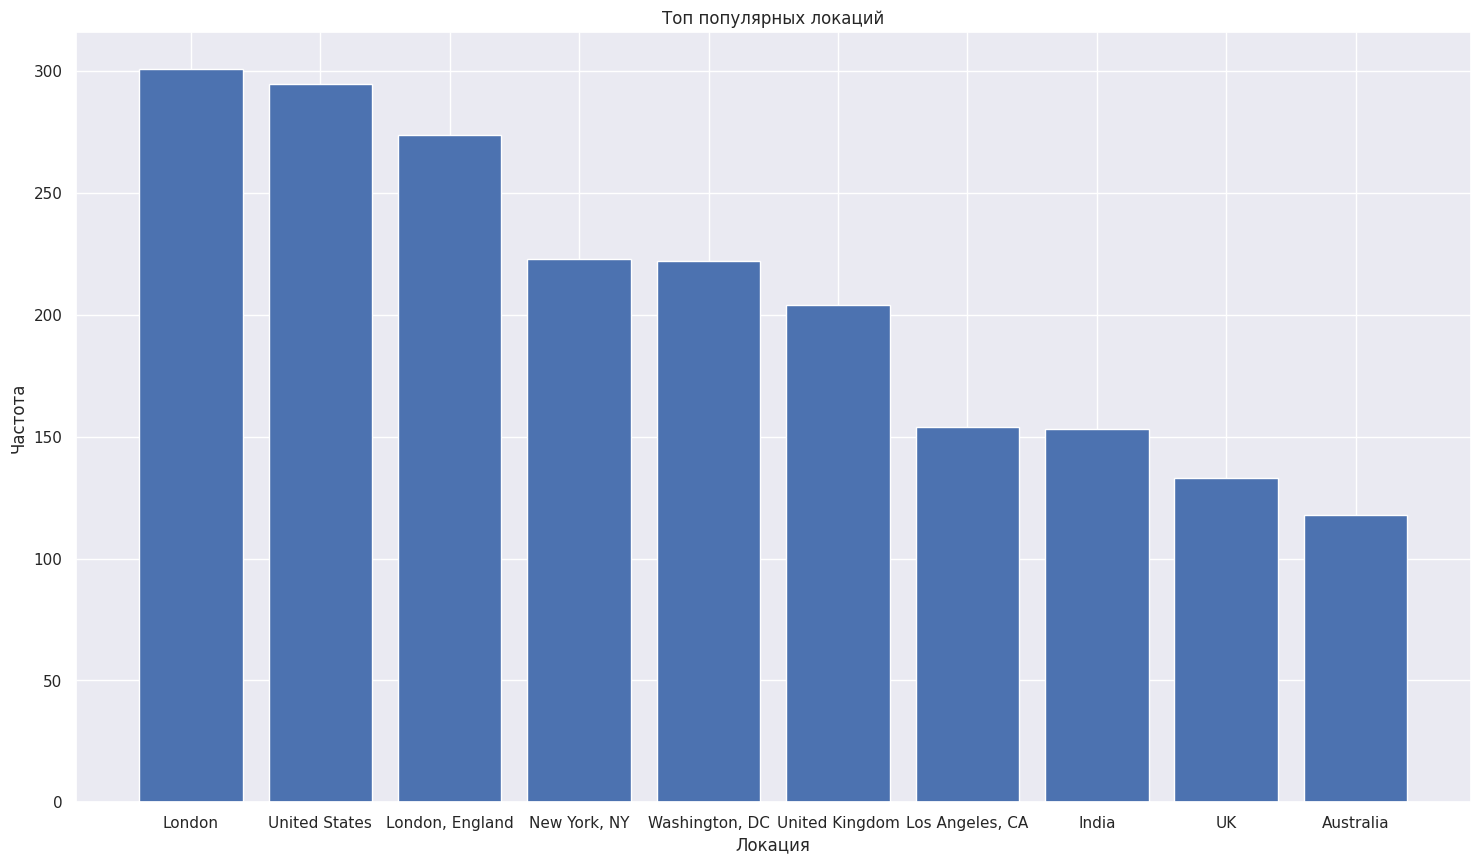

In [46]:
# -- YOUR CODE HERE --

df_location = train[train['Location'] != 'Unknown']
locations = df_location['Location'].value_counts(ascending=False)
plt.bar(locations.index[:10],locations.values[:10])
plt.title('Топ популярных локаций')
plt.xlabel('Локация')
plt.ylabel('Частота')
plt.show()



Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [47]:
# -- YOUR CODE HERE --
new_loc = []
for location in train['Location']:

  wide = location.split(',')[-1] # берем последнюю часть каждого местоположения после запятой
  if wide.split(' ')[-1] == '': #  если последний элемент после разделения на пробелы пустой, то есть перед ним нет пробела, то он является самым широким местоположением.
    new_loc.append(wide)
  else:
    new_loc.append(wide.split(' ')[-1]) # - если последний элемент после разделения на пробелы пустой, то есть перед ним нет пробела, то он является самым широким местоположением
train['WiderLocation'] = new_loc
print('Количество уникальных значений:', len(train['WiderLocation'].unique()))

Количество уникальных значений: 3410


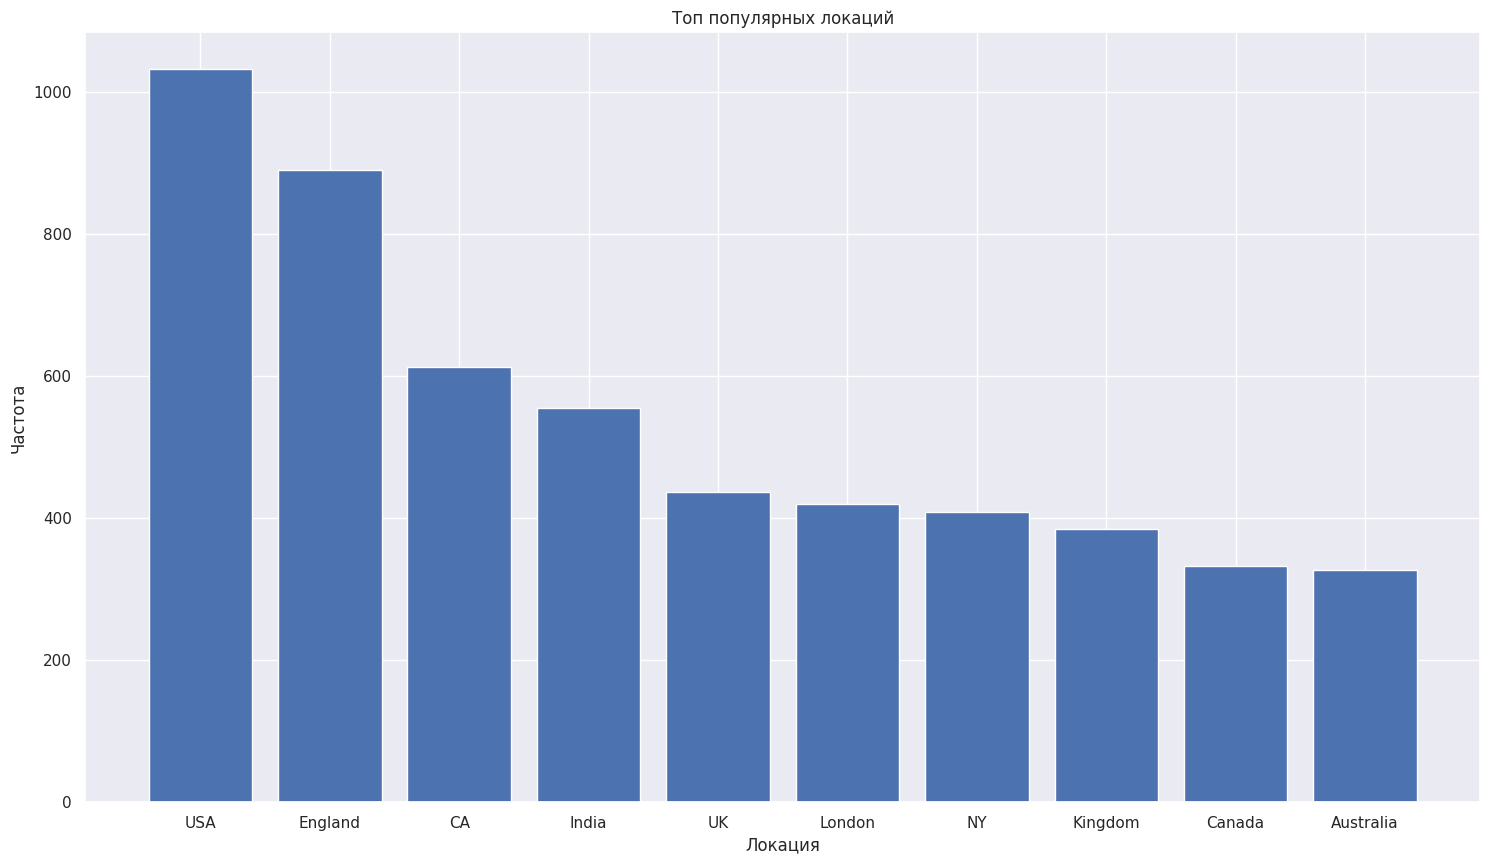

In [48]:
df_location = train[train['WiderLocation'] != 'Unknown']
locations = df_location['WiderLocation'].value_counts(ascending=False)
plt.bar(locations.index[:10],locations.values[:10])
plt.title('Топ популярных локаций')
plt.xlabel('Локация')
plt.ylabel('Частота')
plt.show()


Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [49]:
# -- YOUR CODE HERE --
popular_locs = locations[locations > 1]
print(f' Количество локаций, встречающихся больше 1 раза : {len(popular_locs)}')



 Количество локаций, встречающихся больше 1 раза : 976


In [50]:
popular_locs = popular_locs.index.tolist()

# теперь создадим новый столбцец для всего теста
new_loc = []
for location in test['Location']:

  wide = location.split(',')[-1] # берем последнюю часть каждого местоположения после запятой
  if wide.split(' ')[-1] == '': #  если последний элемент после разделения на пробелы пустой, то есть перед ним нет пробела, то он является самым широким местоположением.
    new_loc.append(wide)
  else:
    new_loc.append(wide.split(' ')[-1]) # - если последний элемент после разделения на пробелы пустой, то есть перед ним нет пробела, то он является самым широким местоположением
test['WiderLocation'] = new_loc


In [51]:
train = train[train['WiderLocation'].isin(popular_locs)]
test = test[test['WiderLocation'].isin(popular_locs)]


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[popular_locs], sparse=False)
train_loc_encoded = encoder.fit_transform(train['WiderLocation'].values.reshape(-1, 1))
test_loc_encoded  = encoder.transform(test['WiderLocation'].values.reshape(-1, 1))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [52]:
# df_ohe = pd.DataFrame(wider_location_encoded, columns = filtered_df['WiderLocation'].unique())
feature_names = encoder.get_feature_names_out(['WiderLocation'])
train_loc_encoded_new = pd.DataFrame(train_loc_encoded, columns=feature_names)
test_loc_encoded_new = pd.DataFrame(test_loc_encoded, columns=feature_names)




Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [53]:
# -- YOUR CODE HERE --
train_new_pd = pd.DataFrame(train_new)
test_new_pd = pd.DataFrame(test_new)

train_new_locations = pd.concat([train_new_pd, train_new], axis = 1, ignore_index = False)
test_new_locations = pd.concat([test_new_pd, test_new] ,axis = 1, ignore_index = False)





In [54]:
clf.fit(train_new_locations, y_train)
pred_train = clf.predict(train_new_locations)
pred_test = clf.predict(test_new_locations)

print(f'accuracy on train = {accuracy_score(y_train, pred_train)}')
print(f'accuracy on test = {accuracy_score(y_test, pred_test)}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy on train = 0.9434856898761214
accuracy on test = 0.8421367351006578


**Ответ:** Можем заметить, что наше результат совсем немого улучшился на трейне, и ухудшился на тесте. Таким образом, признак оказался бесполезным.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [56]:
# -- YOUR CODE HERE --


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
